<a href="https://colab.research.google.com/github/Bilgetug/Pokemon-Generator-GENAI/blob/main/Pokemon_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()
!unzip -q archive.zip -d pokemon_dataset
import os
print(os.listdir('pokemon_dataset/images')[:10])  # Should show image files

Saving archive.zip to archive.zip
['Pidgey', 'Toxicroak', 'Burmy', 'Hakamo-o', 'Furfrou', 'Reshiram', 'Sandaconda', 'Watchog', 'Swellow', 'Porygon2']


In [2]:
import os
import torch
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)


Using: cuda


In [3]:
class PokemonDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        for subfolder in os.listdir(root_dir):
            subfolder_path = os.path.join(root_dir, subfolder)
            if os.path.isdir(subfolder_path):
                for file in os.listdir(subfolder_path):
                    if file.endswith(('.png', '.jpg', '.jpeg')):
                        self.image_paths.append(os.path.join(subfolder_path, file))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = PokemonDataset(root_dir='pokemon_dataset/images', transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


In [4]:
class Generator(nn.Module):
    def __init__(self, noise_dim=100, channels_img=3, features_g=64):
        super().__init__()
        self.net = nn.Sequential(
            self._block(noise_dim, features_g * 16, 4, 1, 0),  # 1x1
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # 4x4
            self._block(features_g * 8, features_g * 4, 4, 2, 1),   # 8x8
            self._block(features_g * 4, features_g * 2, 4, 2, 1),   # 16x16
            nn.ConvTranspose2d(features_g * 2, channels_img, 4, 2, 1),
            nn.Tanh()
        )

    def _block(self, in_c, out_c, k, s, p):
        return nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, k, s, p, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(True),
        )

    def forward(self, x):
        return self.net(x)


In [5]:
class Discriminator(nn.Module):
    def __init__(self, channels_img=3, features_d=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels_img, features_d, 4, 2, 1),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            nn.Conv2d(features_d * 8, 1, 4, 1, 0),
            nn.Sigmoid()
        )

    def _block(self, in_c, out_c, k, s, p):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, k, s, p, bias=False),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.net(x).view(-1)


In [6]:
noise_dim = 100
G = Generator(noise_dim=noise_dim).to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()
opt_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

fixed_noise = torch.randn(64, noise_dim, 1, 1, device=device)


In [7]:
G_losses = []
D_losses = []

epochs = 150
for epoch in range(epochs):
    for batch in dataloader:
        batch = batch.to(device)
        b_size = batch.size(0)

        # === Train Discriminator ===
        noise = torch.randn(b_size, noise_dim, 1, 1, device=device)
        fake = G(noise)

        real_labels = torch.ones(b_size, device=device)
        fake_labels = torch.zeros(b_size, device=device)

        D_real = D(batch)
        D_fake = D(fake.detach())

        loss_D_real = criterion(D_real, real_labels)
        loss_D_fake = criterion(D_fake, fake_labels)
        loss_D = loss_D_real + loss_D_fake

        D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # === Train Generator ===
        output = D(fake)
        loss_G = criterion(output, real_labels)

        G.zero_grad()
        loss_G.backward()
        opt_G.step()

    # === Track losses ===
    G_losses.append(loss_G.item())
    D_losses.append(loss_D.item())

    # === Save every image ===
    if (epoch + 1) % 10 == 0 or epoch == 0:
        G.eval()
        with torch.no_grad():
            fakes = G(fixed_noise).detach().cpu()
        G.train()

        grid = vutils.make_grid(fakes, normalize=True)
        plt.figure(figsize=(8, 8))
        plt.axis("off")
        plt.title(f"Epoch {epoch+1} - Generated Pokémon")
        plt.imshow(np.transpose(grid, (1, 2, 0)))
        plt.savefig(f"generated_epoch_{epoch+1}.png")
        plt.close()

    print(f"Epoch [{epoch+1}/{epochs}] complete. G_loss: {loss_G.item():.4f}, D_loss: {loss_D.item():.4f}")

Epoch [1/150] complete. G_loss: 8.0430, D_loss: 0.1363
Epoch [2/150] complete. G_loss: 11.9803, D_loss: 0.0125
Epoch [3/150] complete. G_loss: 1.5224, D_loss: 1.2343
Epoch [4/150] complete. G_loss: 2.7603, D_loss: 0.5661
Epoch [5/150] complete. G_loss: 2.8247, D_loss: 1.5409
Epoch [6/150] complete. G_loss: 2.5611, D_loss: 1.1925
Epoch [7/150] complete. G_loss: 2.7074, D_loss: 0.8418
Epoch [8/150] complete. G_loss: 3.1426, D_loss: 0.7462
Epoch [9/150] complete. G_loss: 3.3750, D_loss: 1.0770
Epoch [10/150] complete. G_loss: 2.1054, D_loss: 2.8888
Epoch [11/150] complete. G_loss: 2.1642, D_loss: 0.9718
Epoch [12/150] complete. G_loss: 3.6689, D_loss: 0.5997
Epoch [13/150] complete. G_loss: 2.1223, D_loss: 0.7269
Epoch [14/150] complete. G_loss: 2.3866, D_loss: 0.6486
Epoch [15/150] complete. G_loss: 3.0059, D_loss: 0.8734
Epoch [16/150] complete. G_loss: 3.4272, D_loss: 0.4621
Epoch [17/150] complete. G_loss: 2.8537, D_loss: 0.8968
Epoch [18/150] complete. G_loss: 3.3890, D_loss: 0.7090


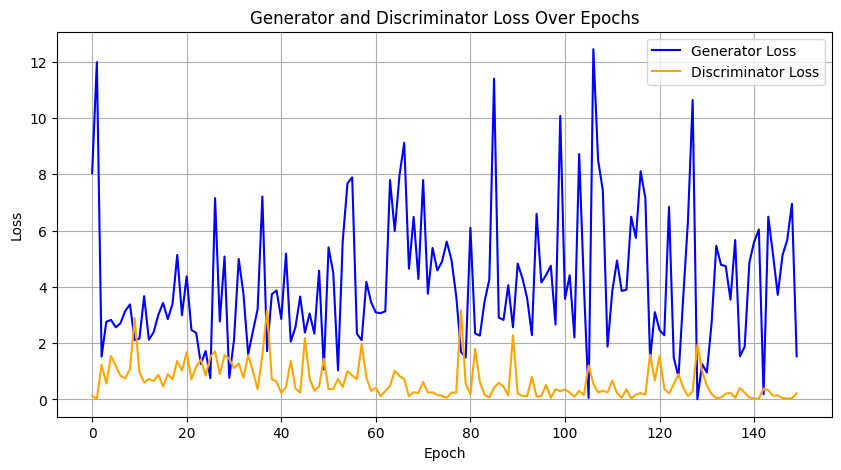

In [8]:
# === Plot loss graph after training ===
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss Over Epochs")
plt.plot(G_losses, label="Generator Loss", color="blue")
plt.plot(D_losses, label="Discriminator Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig("loss_curve.png")
plt.show()

In [11]:
import glob
import re

# Sort based on the numeric part of the filename
images = sorted(
    glob.glob("generated_epoch_*.png"),
    key=lambda x: int(re.search(r"(\d+)", x).group(1))
)
print(images)

import imageio
from PIL import Image

# Load images and create GIF
frames = [Image.open(img) for img in images]
frames[0].save(
    "pokemon_training.gif",
    save_all=True,
    append_images=frames[1:],
    duration=500,  # 500ms per frame
    loop=0
)


['generated_epoch_1.png', 'generated_epoch_10.png', 'generated_epoch_20.png', 'generated_epoch_30.png', 'generated_epoch_40.png', 'generated_epoch_50.png', 'generated_epoch_60.png', 'generated_epoch_70.png', 'generated_epoch_80.png', 'generated_epoch_90.png', 'generated_epoch_100.png', 'generated_epoch_110.png', 'generated_epoch_120.png', 'generated_epoch_130.png', 'generated_epoch_140.png', 'generated_epoch_150.png']


In [12]:
from google.colab import files
files.download("generated_epoch_150.png")       # or any image
files.download("pokemon_training.gif")          # your training GIF
files.download("loss_curve.png")                # the loss graph

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>